In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

# Loading and examning data

In [2]:
X, Y = load_planar_dataset()

Text(0, 0.5, 'X2')

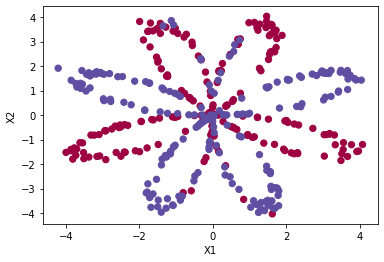

In [3]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
plt.xlabel("X1")
plt.ylabel("X2")

In [4]:
print("The shape of X is: ", X.shape)
print("The shape of Y is: ", Y.shape)
print("Number of traning example: ", X.shape[1])

The shape of X is:  (2, 400)
The shape of Y is:  (1, 400)
Number of traning example:  400


# Using simple logistic regression model in sklearn library 

c:\users\hoang\anaconda3\envs\d2l\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


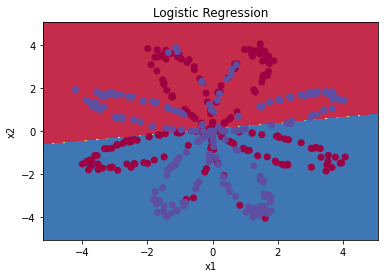

In [5]:
# Train the logistic regression
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

# NN model with one hidden layer



<img src="images/classification_kiank.png" style="width:600px;height:300px;">

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

The general methodology to build a Neural Network is to:
   1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
   2. Initialize the model's parameters
   3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

## Build model

In [6]:
class NNmodel:
    def __init__(self):
        self.parameters = {}  # store W, b
        self.cache = {}  # store Z, A
        self.grads = {}  # store dZ, dW, db
        self.costs = list()  # store all the cost value

    def initialize_parameters(self, n_x, n_h, n_y):
        np.random.seed(2)
        W1 = np.random.randn(n_h, n_x)*0.01
        b1 = np.zeros((n_h, 1))
        W2 = np.random.randn(n_y, n_h)*0.01
        b2 = np.zeros((n_y, 1))

        parameters = {
            'W1': W1,
            'b1': b1,
            'W2': W2,
            'b2': b2
        }

        return parameters

    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))
        return a

    def tanh(self, z):
        a = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
        return a

    def forward(self, X):
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']

        Z1 = np.dot(W1, X) + b1
        A1 = self.tanh(Z1)  # hidden layer
        Z2 = np.dot(W2, A1) + b2
        A2 = self.sigmoid(Z2)  # output layer

        self.cache = {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
        return self.cache['A2']

    def backward(self, X, Y):
        W1 = self.parameters['W1']
        W2 = self.parameters['W2']

        A1 = self.cache['A1']
        A2 = self.cache['A2']

        m = X.shape[1]

        dZ2 = A2 - Y
        dW2 = (1/m)*(np.dot(dZ2, A1.T))
        db2 = (1/m)*(np.sum(dZ2, axis=1, keepdims=True))
        dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
        dW1 = (1/m)*np.dot(dZ1, X.T)
        db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }
        return

    def update_parameters(self, lr):
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']

        W1 = W1 - lr*self.grads['dW1']
        b1 = b1 - lr*self.grads['db1']
        W2 = W2 - lr*self.grads['dW2']
        b2 = b2 - lr*self.grads['db2']

        self.parameters = {
            'W1': W1,
            'b1': b1,
            'W2': W2,
            'b2': b2
        }
        return

    def compute_cost(self, A2, Y):
        m = Y.shape[1]
        cost = - (np.dot(np.log(A2), Y.T) + np.dot(np.log(1-A2), (1-Y).T)) / m
        cost = np.squeeze(cost)
        return cost

    def fit(self, X, Y, n_h, lr=0.05, iters=2000, printCost=False):
        n_x = X.shape[0]
        n_y = Y.shape[0]

        # initialize parameters
        self.parameters = self.initialize_parameters(n_x, n_h, n_y)

        for i in range(iters):
            A2 = self.forward(X)
            cost = self.compute_cost(A2, Y)
            self.costs.append(cost)
            self.backward(X, Y)
            self.update_parameters(lr)
            if i % 1000 == 0 and printCost:
                print("Cost after {} iterations: {}".format(i, cost))
        return
    
    def predict(self, X):
        predictions = np.round(self.forward(X))
        return predictions
    
    def accuracy(self, X, Y):
        predictions = self.predict(X)
        accur = np.squeeze(100.0 - np.mean(np.abs(predictions - Y))*100)
        return accur
        

## play around with model

In [7]:
m1 = NNmodel()

In [8]:
X.shape

(2, 400)

In [9]:
m1.fit(X, Y, n_h=4, lr=1.2, iters=10000)

In [10]:
m1.accuracy(X, Y)

90.75

## Try with different number of hidden layer size

In [11]:
def train_different_n_h(hidden_layer_size, X, Y):
    plt.figure(figsize=(16, 32))
    for i, n_h in enumerate(hidden_layer_size):
        plt.subplot(5,2,i+1)
        plt.title('Hidden Layer of size {}'.format(n_h))
        model = NNmodel()
        model.fit(X, Y, n_h, lr=1.2, iters=5000)
        plot_decision_boundary(lambda x: model.predict(x.T), X, Y)
        accuracy = model.accuracy(X, Y)
        print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.75 %
Accuracy for 50 hidden units: 90.75 %
Accuracy for 100 hidden units: 91.0 %


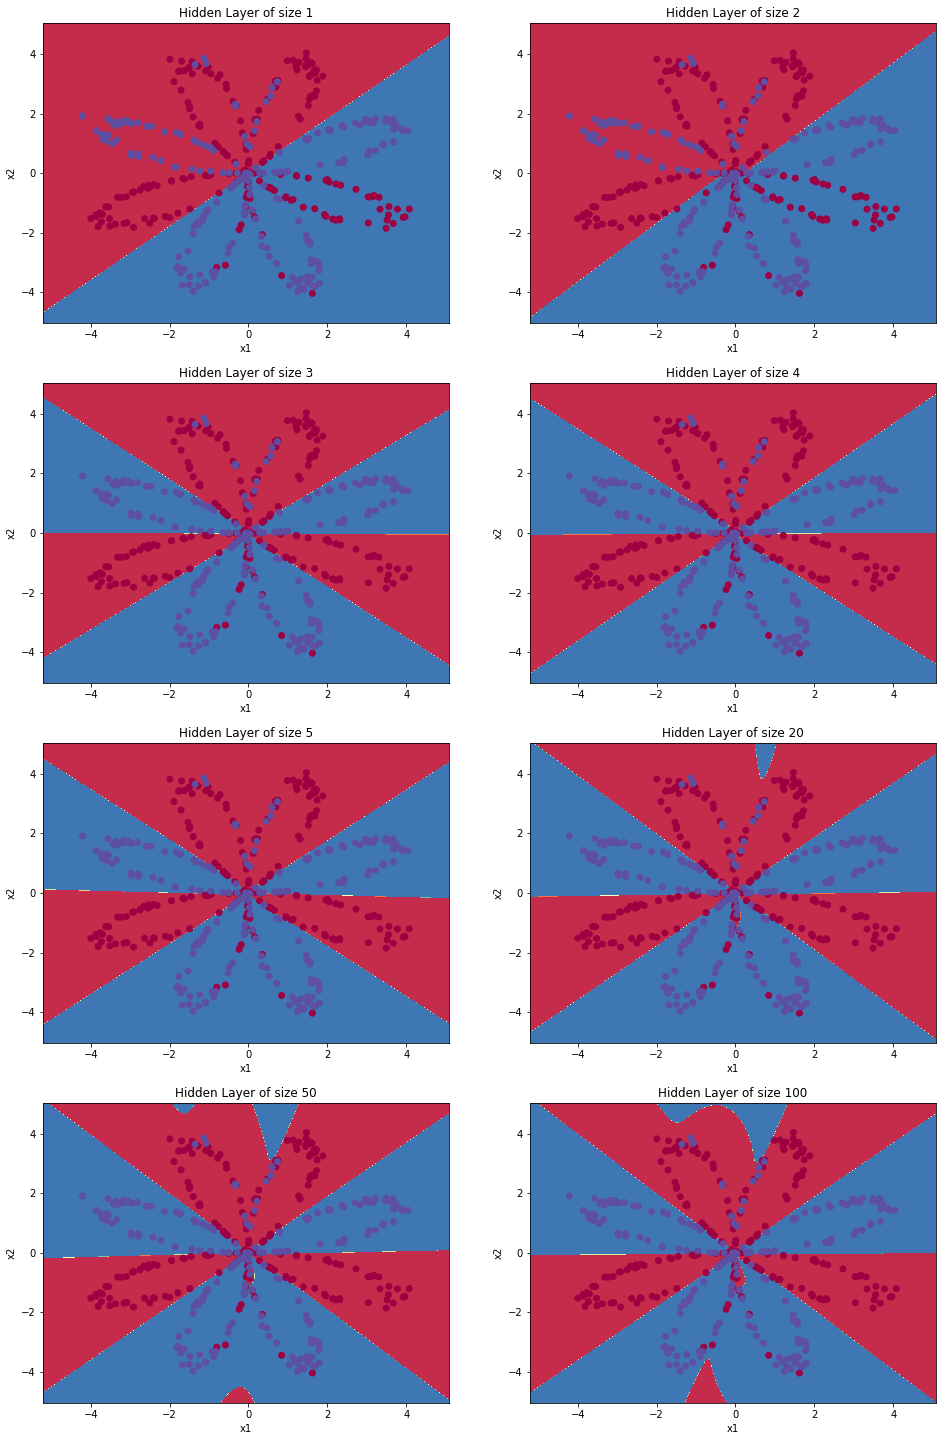

In [12]:
hidden_layer_size = [1,2,3,4,5,20,50,100]
train_different_n_h(hidden_layer_size, X, Y)

- With more hidden units we are able to fit the training set better, but too large can lead to overfit the data
- The best hidden layer size observed above around n_h = 5.

# Try on different datasets

In [13]:
def choose_dataset(dataset):
    noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

    datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}
    return datasets[dataset]

In [14]:
dataset = "blobs"

X, Y = choose_dataset(dataset)

# make blobs binary
if dataset == "blobs":
    Y = Y%2

In [15]:
np.unique(Y)

array([0, 1], dtype=int32)

In [16]:
X.shape, Y.shape

((200, 2), (200,))

In [17]:
X, Y = X.T, Y.reshape(1, -1)

In [18]:
X.shape, Y.shape

((2, 200), (1, 200))

Text(0, 0.5, 'X2')

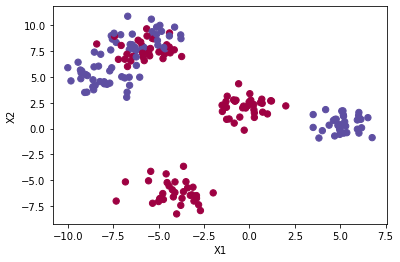

In [19]:
# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
plt.xlabel("X1")
plt.ylabel("X2")

Accuracy for 1 hidden units: 67.0 %
Accuracy for 5 hidden units: 83.0 %
Accuracy for 10 hidden units: 82.5 %
Accuracy for 20 hidden units: 87.5 %
Accuracy for 50 hidden units: 83.5 %
Accuracy for 100 hidden units: 86.5 %


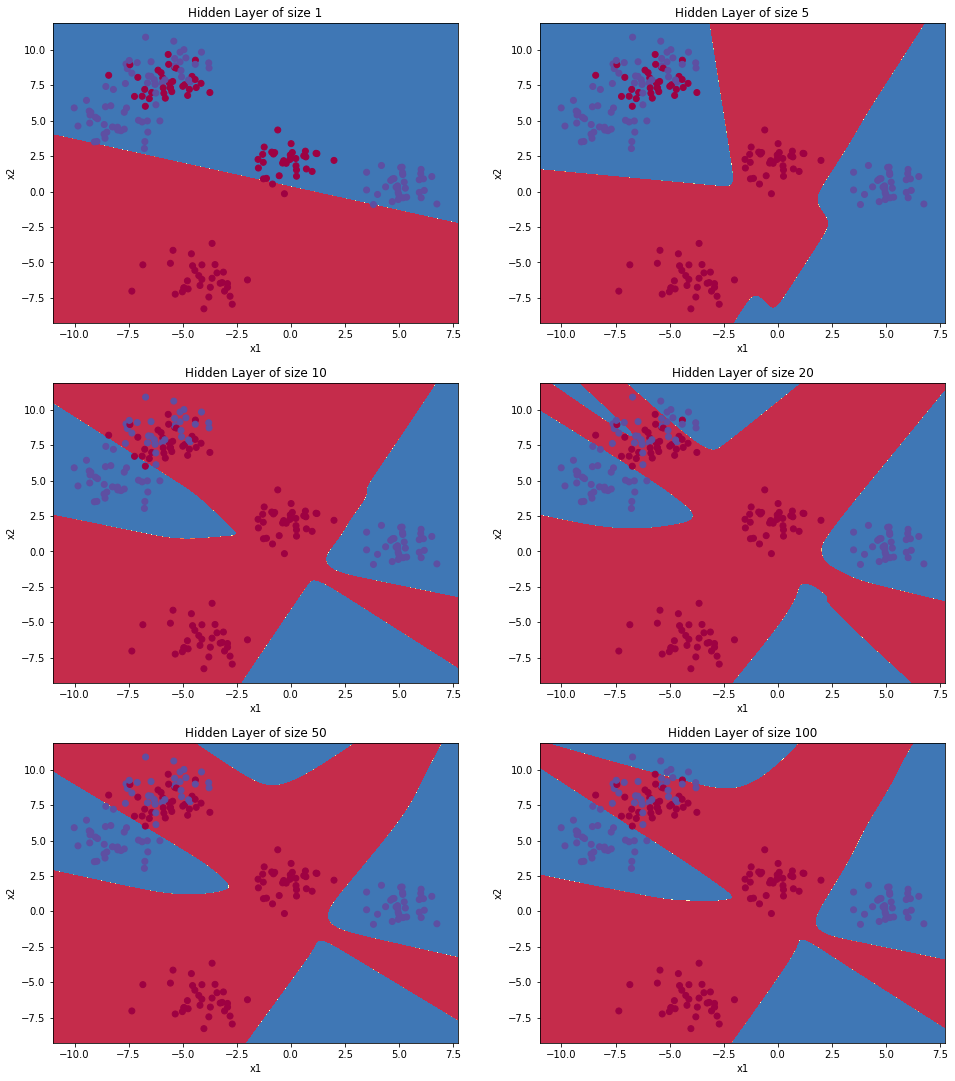

In [20]:
model = NNmodel()
hidden_layer_size = [1,5,10,20,50,100]
train_different_n_h(hidden_layer_size, X, Y)
